In [31]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


Import the ISOT dataset

In [32]:
isot_fake = pd.read_csv('isot_dataset/fake.csv')
isot_true = pd.read_csv('isot_dataset/true.csv')

Check the columns and rename text into statement. This has been done based on the columns in the other dataset.

In [33]:
print(isot_fake.columns)
print(isot_true.columns)

isot_fake.columns = ['title','statement', 'subject', 'date']
isot_true.columns = ['title','statement', 'subject', 'date']

Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')


Drop unnecessary columns:

In [34]:
isot_fake = isot_fake.drop(['title', 'subject', 'date'], axis=1)
isot_true = isot_true.drop(['title', 'subject', 'date'], axis=1)

Add a label column to the datasets:

In [35]:
isot_fake['label'] = "False"
isot_true['label'] = "True"

Combine the datasets and shuffle the rows:

In [36]:
isot_combined = pd.concat([isot_fake, isot_true], ignore_index=True)
isot_combined = isot_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(isot_combined)

                                               statement  label
0      21st Century Wire says Ben Stein, reputable pr...  False
1      WASHINGTON (Reuters) - U.S. President Donald T...   True
2      (Reuters) - Puerto Rico Governor Ricardo Rosse...   True
3      On Monday, Donald Trump once again embarrassed...  False
4      GLASGOW, Scotland (Reuters) - Most U.S. presid...   True
...                                                  ...    ...
44893                                                     False
44894  LONDON/TOKYO (Reuters) - British Prime Ministe...   True
44895  BERLIN (Reuters) - Chancellor Angela Merkel sa...   True
44896  Jesus f*cking Christ our President* is a moron...  False
44897  IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...  False

[44898 rows x 2 columns]


Split the dataset into training, testing and validation sets usigng 80-10-10:

In [37]:
train_data, temp_data = train_test_split(isot_combined, test_size=0.8, random_state=42, stratify=isot_combined['label'])
test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

Remove whitespace lines:

In [38]:
isot_train_data = train_data[train_data['statement'].str.strip().astype(bool)]
isot_test_data = test_data[test_data['statement'].str.strip().astype(bool)]
isot_valid_data = valid_data[valid_data['statement'].str.strip().astype(bool)]

Remove duplicate rows if any:

In [39]:
isot_train_data = isot_train_data.drop_duplicates(subset='statement')
isot_test_data = isot_test_data.drop_duplicates(subset='statement')
isot_valid_data = isot_valid_data.drop_duplicates(subset='statement')

The following function is used to clean the text. It converts the text to lowercase and removes URLs and extra spaces:
- The text is lowercased to ensure that the model does not treat the same word with different cases as different words.
- URLs and extra spaces are removed because they do not provide any useful information for the model.

In [40]:
def clean_text(text):
    text = text.lower() # lowercase text
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

Clean the text in the dataset:

In [41]:
isot_train_data['statement'] = isot_train_data['statement'].apply(clean_text)
isot_test_data['statement'] = isot_test_data['statement'].apply(clean_text)
isot_valid_data['statement'] = isot_valid_data['statement'].apply(clean_text)

The following function is used to fix the number format. It replaces commas in numbers ('15,000' -> '15000'):

In [42]:
def fix_number_format(text):
    # Replace commas in numbers ('15,000' -> '15000')
    text = re.sub(r'(\d),(\d)', r'\1\2', text)
    return text

Fix the number format in the dataset:

In [43]:
isot_train_data['statement'] = isot_train_data['statement'].apply(fix_number_format)
isot_test_data['statement'] = isot_test_data['statement'].apply(fix_number_format)
isot_valid_data['statement'] = isot_valid_data['statement'].apply(fix_number_format)

Remove null lines:

In [44]:
isot_train_data = isot_train_data[isot_train_data['statement'].str.strip().astype(bool)]
isot_test_data = isot_test_data[isot_test_data['statement'].str.strip().astype(bool)]
isot_valid_data = isot_valid_data[isot_valid_data['statement'].str.strip().astype(bool)]


Save the preprocessed datasets:

In [45]:
isot_train_data.to_csv('preprocessed_isot/isot_train.csv', index=False)
isot_test_data.to_csv('preprocessed_isot/isot_test.csv', index=False)
isot_valid_data.to_csv('preprocessed_isot/isot_valid.csv', index=False)

Check the distribution of text length in the training set:

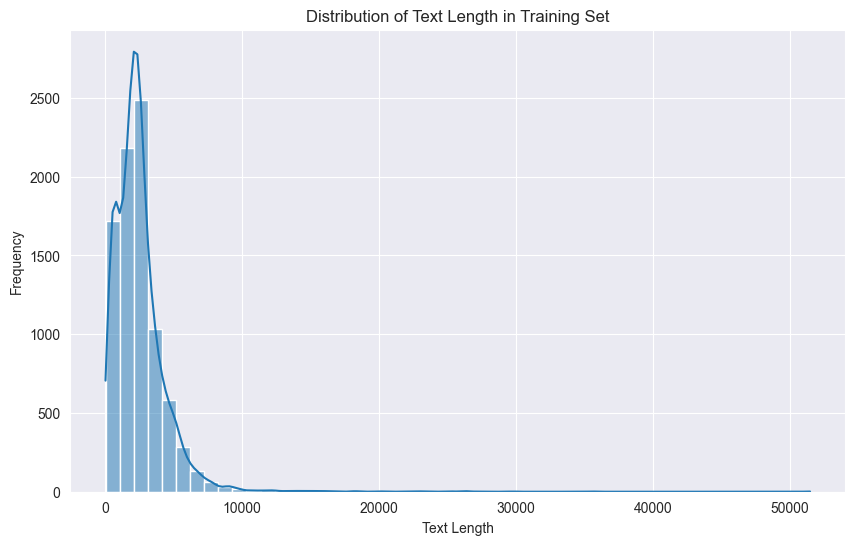

In [46]:
isot_train_data['text_length'] = isot_train_data['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(isot_train_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the class distribution in the training set:

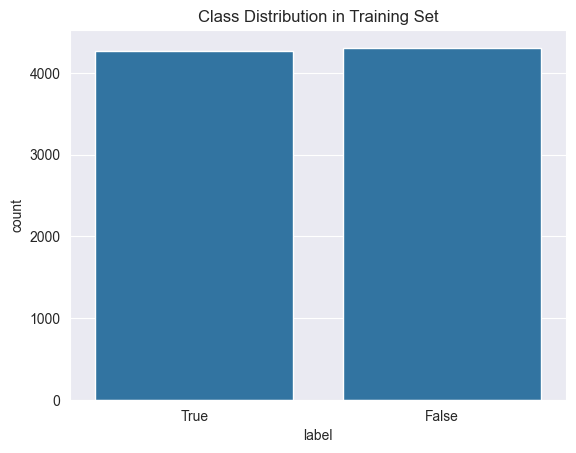

In [47]:
sns.countplot(x='label', data=isot_train_data)
plt.title('Class Distribution in Training Set')
plt.show()

Check the length of text by class in the training set:

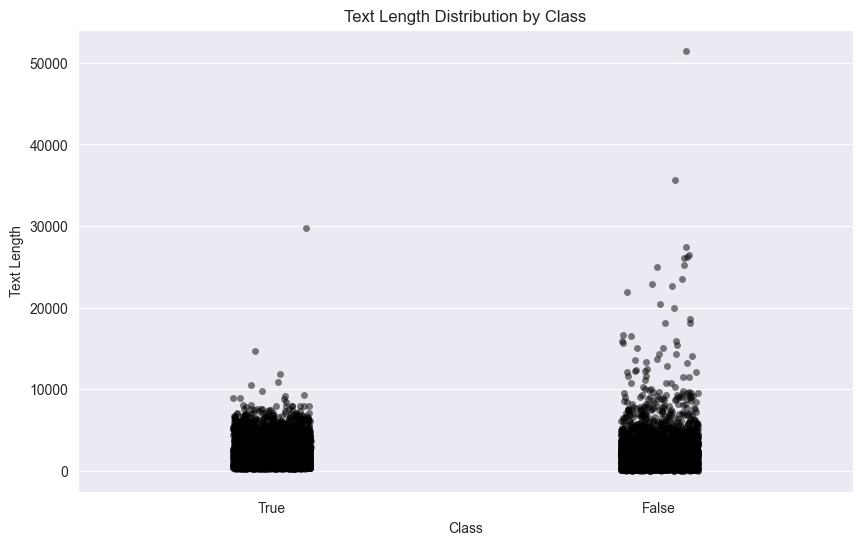

In [48]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=isot_train_data, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the word frequency in the training set:

In [49]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
X = vectorizer.fit_transform(isot_train_data['statement'])

# Get the words and their frequencies
words = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
word_freq = dict(zip(words, frequencies))

# Sort and display the top 10 frequent words

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq)

[('trump', np.int64(26227)), ('said', np.int64(25945)), ('president', np.int64(10801)), ('people', np.int64(8107)), ('state', np.int64(6667)), ('new', np.int64(6050)), ('reuters', np.int64(5990)), ('donald', np.int64(5591)), ('government', np.int64(5549)), ('clinton', np.int64(5459)), ('republican', np.int64(5370)), ('obama', np.int64(5297)), ('states', np.int64(5235)), ('donald trump', np.int64(5224)), ('house', np.int64(5187)), ('just', np.int64(4945)), ('year', np.int64(4781)), ('united', np.int64(4558)), ('told', np.int64(4555)), ('campaign', np.int64(4405)), ('like', np.int64(4381)), ('white', np.int64(4325)), ('party', np.int64(4247)), ('time', np.int64(4196)), ('election', np.int64(4114)), ('news', np.int64(3894)), ('united states', np.int64(3709)), ('country', np.int64(3689)), ('washington', np.int64(3683)), ('years', np.int64(3312)), ('hillary', np.int64(3251)), ('did', np.int64(3193)), ('american', np.int64(3095)), ('security', np.int64(3063)), ('political', np.int64(3036)), 

Plot the top 10 frequent words in the training set:

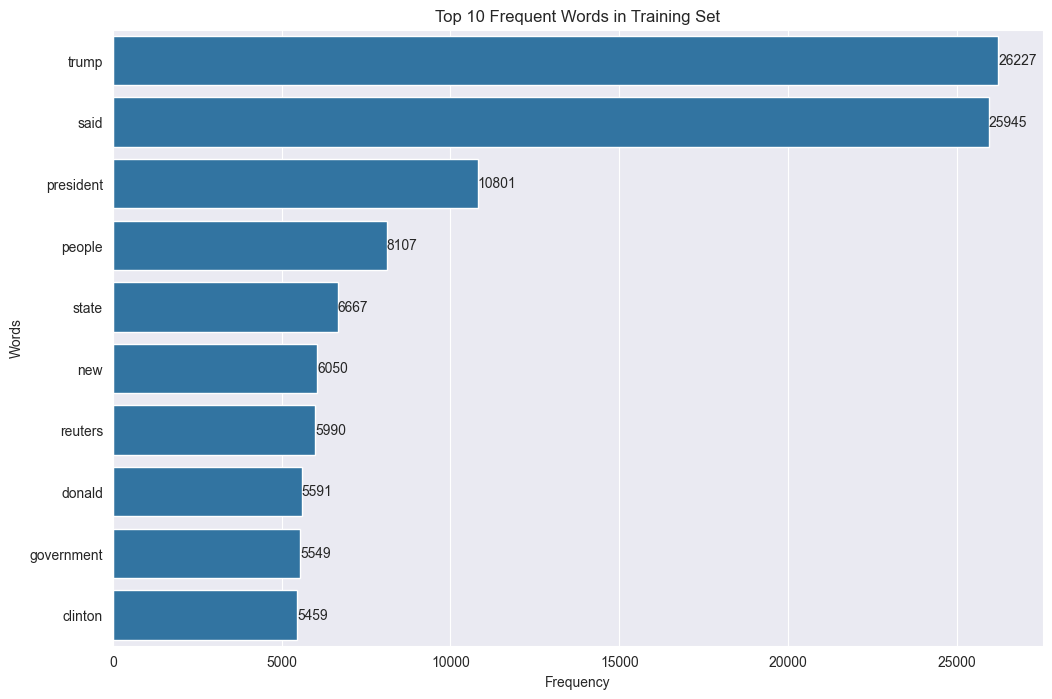

In [50]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_word_freq[:10]], y=[item[0] for item in sorted_word_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_word_freq[:10]]):
    plt.text(value, index, str(value), va='center')
plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()